## Group 15 Jupyter Notebook Report

### He Wei, Wan Liuyang, Dong linsen, Siow Jing Kai


## 1. Project Motivation 


Image Segmentation are commonly used in computer vision to isolate Person of Interest or Object of Interest. Individual analysis could be done for each component of the images after segmentation. Some of the commonly used techniquesinclude edge detection, thresholding and clustering segmentation. In the recent years, more and more deep learning techniques are used to understand the underlying structure of an image and used these understanding in segmentating important part of the image. The goal of the project is extract the portion of the image where it represents the car.

In this project, the team explored the use of Convolutional Neural Network on understanding high resolutions car images. This will involves the evaluations of two recent works, ICNet and TeranusNet. Furthermore, we proposed an ensemble method that will combine the results of both networks to improve accuracy of the segmentations. 

# 2.Data acquisition

## 2.1 Kaggle Dataset
This project originate from a kaggle competition[https://www.kaggle.com/c/carvana-image-masking-challenge], hence the dataset are provided by the kaggle API. There are around 5000 training images and 100,000 testing images. 

The steps to download the Kaggle Dataset are as follows:
1. Install kaggle API: pip install kaggle
2. Create API token from https://www.kaggle.com/<username>/account and save the file to ~/.kaggle/kaggle.json
3. Download the Carvana dataset: kaggle competitions download -c carvana-image-masking-challenge
4. Unzip the dataset into to ./data/train ./data/valid ./data/test

The following structure shows the data folder structure:
```
./ (local folder)
│   ...
└───data
    │ train
    │ valid
```

To validate our model more effectively, we splited the training images to 4000 images for training and 1000 images for testing and validation. 

The original 100,000 testing images will be used to evaluate our model and prove that our results can reach the top 10% of the kaggle leaderboard. The scripts for spliting the training data will be provided below.

The dataset should have the following structure:
```
./ (local folder)
│   ...
└───data
    ├─train
    │	├─data
    │	└─mask
    └─valid
	├─data
    	└─mask
```


In [ ]:
import os
import pandas as pd
import shutil
from PIL import Image
from data import DATA_PATH
from glob import glob

base_dir = './data/'
all_img_df = pd.DataFrame(dict(path=glob(os.path.join(base_dir, 'train', '*.*'))))
all_img_df['key_id'] = all_img_df['path'].map(lambda x: splitext(os.path.basename(x))[0])
all_img_df['car_id'] = all_img_df['key_id'].map(lambda x: x.split('_')[0])
all_img_df['mask_path'] = all_img_df['path'].map(
    lambda x: x.replace('train', '_train_masks').replace('.jpg', '_mask.png'))
all_img_df['exists'] = all_img_df['mask_path'].map(os.path.exists)
print(all_img_df['exists'].value_counts())
all_img_df.sample(3)

_, t_row = next(all_img_df.sample(1).iterrows())
make_change_figure(t_row).savefig('overview.png', dpi=300)
a, c = read_diff_img(t_row)
print(a.shape, c.shape)

train_df, valid_df = train_test_split_on_group(all_img_df, col_id='car_id', random_state=2018, test_size=0.2)
valid_df, test_df = train_test_split_on_group(valid_df, col_id='car_id', random_state=2018, test_size=0.5)
print(train_df.shape[0], 'training images')
print(valid_df.shape[0], 'validation images')
print(test_df.shape[0], 'test images')

save_train_df = train_df.loc[:, ['path', 'mask_path']]
save_valid_df = valid_df.loc[:, ['path', 'mask_path']]
save_test_df = test_df.loc[:, ['path', 'mask_path']]

f = open("../valid.csv", "rb")
list = pd.read_csv(f)

data_destination = os.path.join(DATA_PATH, 'Kaggle/valid/data')
mask_destination = os.path.join(DATA_PATH, 'Kaggle/valid/mask')

if not os.path.exists(data_destination):
    os.makedirs(data_destination)

if not os.path.exists(mask_destination):
    os.makedirs(mask_destination)

data = list['path'].tolist()
masks = list['mask_path'].tolist()

'''Copy files to this project'''
for images in data:
    shutil.copy(images, data_destination)

for mask in masks:
    im = Image.open(mask)
    image_name = mask.split('/')[-1]
    image_name = image_name.replace('gif', 'png')
    im.save(os.path.join(mask_destination, image_name))
    #shutil.copy(mask,mask_destination)


## 2.2 Data Scraping from the Internet Using Scrapy 

Furthermore, we validate our model with real-life car images so that evaluation can be done to the model. These car images are crawled from the website[https://www.pexels.com/search/car/]. We have crawled about 1000 images of the car. These images are in very high resolutions, some of them are in 5000x5000 pixels. The team had manually confirmed that these images are relevant to the car images. In short, after filtering out unrelated images, we have about 600 scraped car images.

The spider.py of the crawler can be found below. The execution of the script requires Scrapy and Selenium environment.


In [ ]:
import scrapy

from crawler.items import CarItem


class CarsSpider(scrapy.Spider):
    name = "cars"

    start_urls = [
        "https://www.pexels.com/search/car/",
    ]

    def parse(self, response):
        for car_item in response.css(".photo-item"):
            url = car_item.css('img::attr("src")').extract_first().split("?")[0]
            yield CarItem(file_urls=[url])

        next_page = response.css('.next_page::attr("href")').extract_first()
        if next_page is not None:
            yield response.follow(next_page, self.parse)


# 3. Data exploration

## 3.1 Introduction and Scripts
To gain an intital understanding of the data, the team performed various data exploration on the dataset. This will help us in understanding why the networks could perform well. The explored statistics are gathered using Python Numpy and scikit-image. The following variables of the data are explored:

* Mean of each RGB Channel E.g Means of Red Channel, Means of Blue Channel, etc
* Variance of each RGB Channel E.g Variance of Red Channel, Variance of Blue Channel, etc
* Standard Deviation of each RGB Channel E.g Standard Deviation of Red Channel, Standard Deviation of Blue Channel, etc
* Heatmap of each RGB Channel E.g Average Pixel Intensity of R Channel, etc
* Percentage of Car Mask in each Images

These data are further plotted into graph and charts to visualize the differences and similarity among them.
The data exploration can be reproduced by using the data_explore.py. First of all, we conduct an summary of all the analysis of the dataset. We generate the means, standard deviation, variance and average RGB intensity of each pixel in one single loop. 

In [1]:
from data_explore import perform_analysis, plot_sb, plot_3d_bar_chart, plot_car_percentage

type_ = 'valid+test'
path = '../data/valid+test'
img_ids, means, stds, vars, avg_pixel = perform_analysis(type_, path)


Processing Dataset of valid+test


/media/jingkai/drive_b/academic/CE7454 Deep Learning for Data Science/master/CE7454_Project_Fall2018_NTU/report/data_explore.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if total_rgb == "":


Data Collection Completed


## 3.2 Means of Each Channel RGB

Plotting of Means of each RGB Channel can be done using the following code. The histogram will shows that the normal distribution among the dataset. 

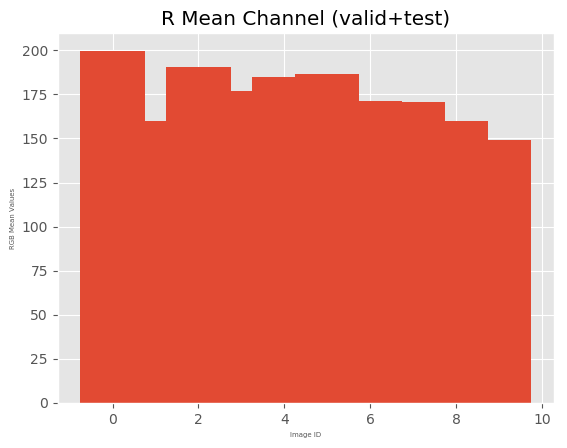

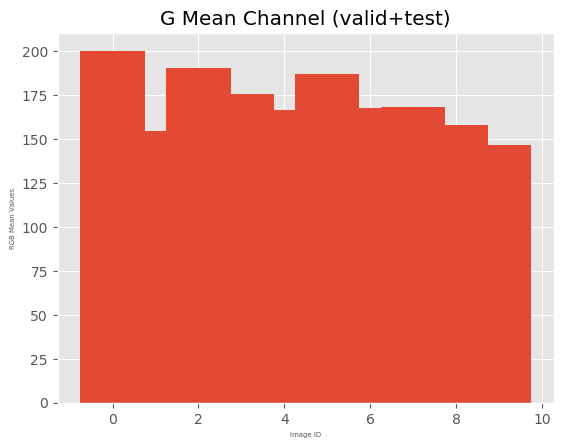

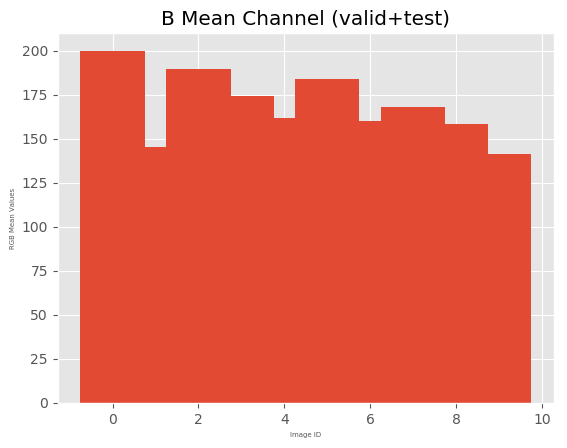

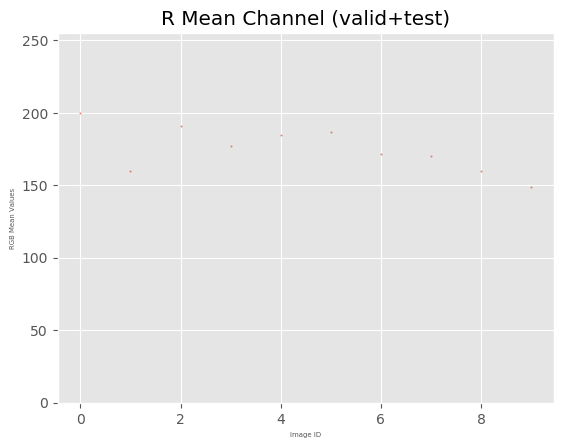

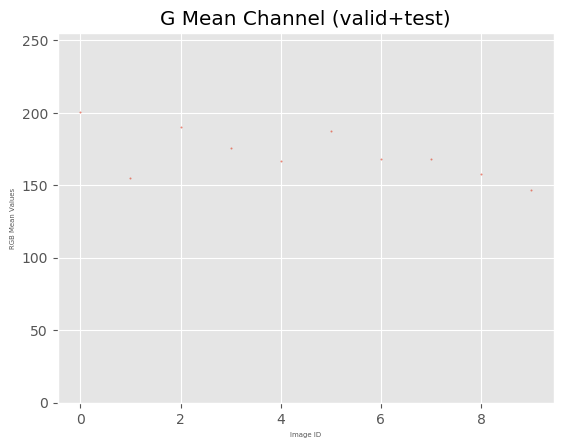

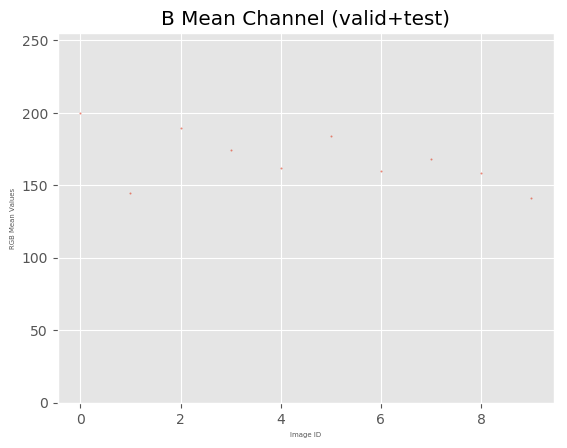

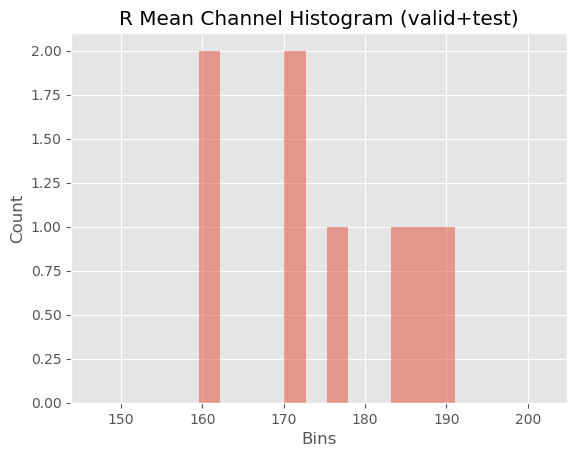

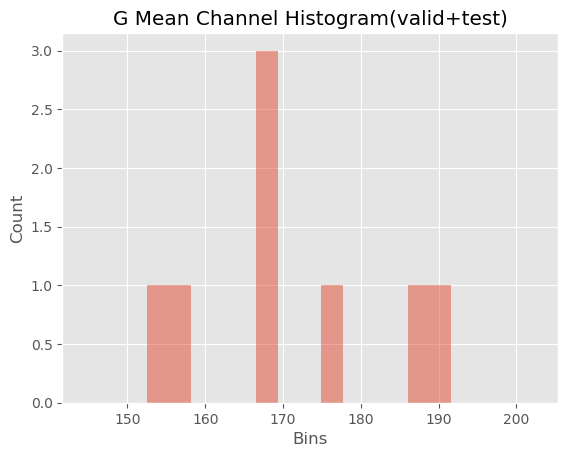

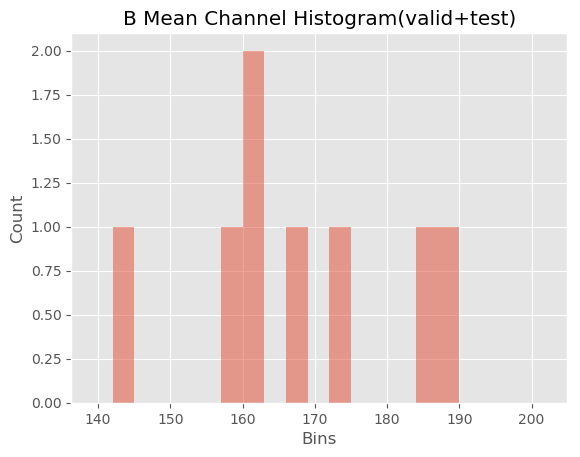

In [2]:
plot_sb(img_ids, means, title="Mean", chart_type="RGB Mean", type_=type_)

## 3.3 Standard Deviation  of Each Channel RGB

Plotting of Standard Deviation  of each RGB Channel can be done using the following code. Furthermore, the standard deviation is arranged into the bins in the histogram. This could shows us a normal distribution among all the images across the standard deviation




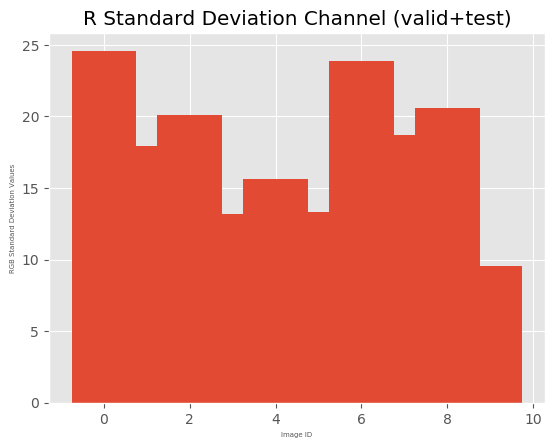

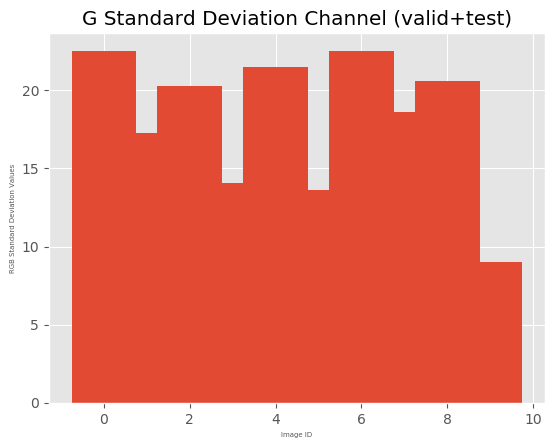

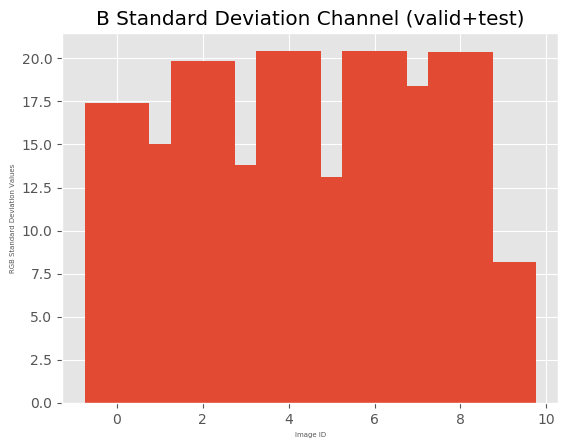

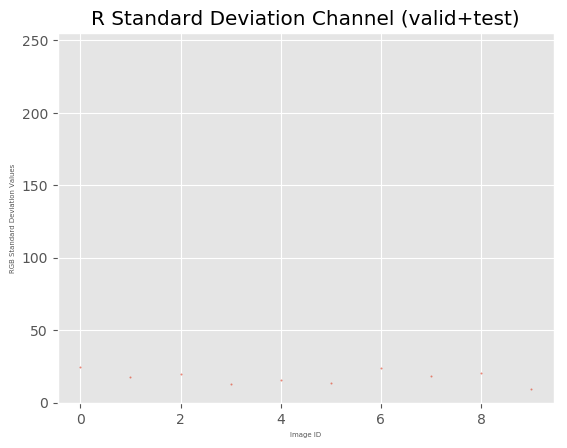

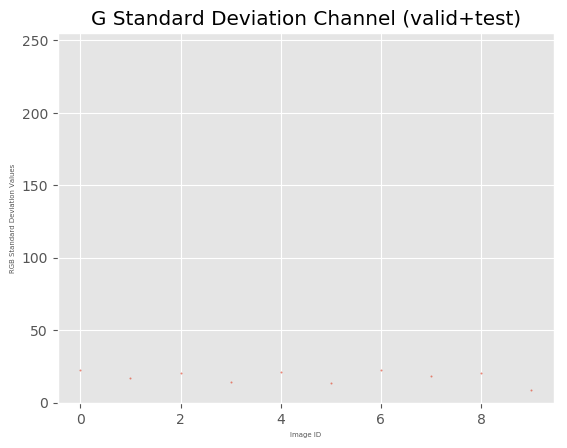

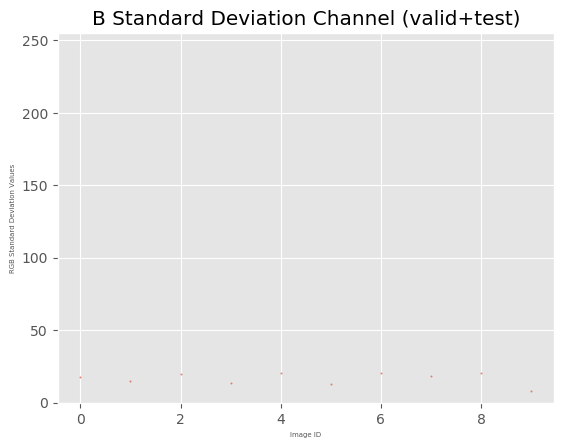

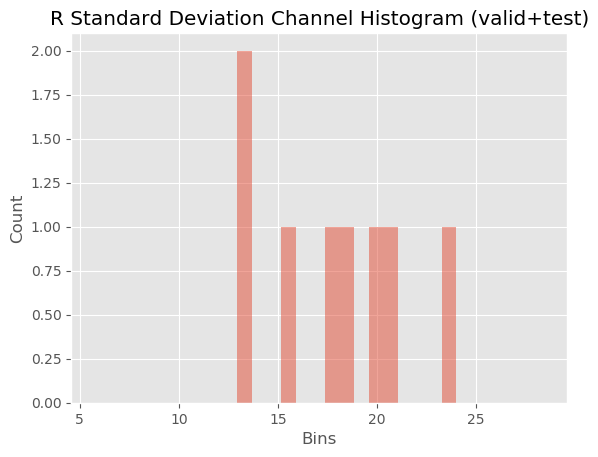

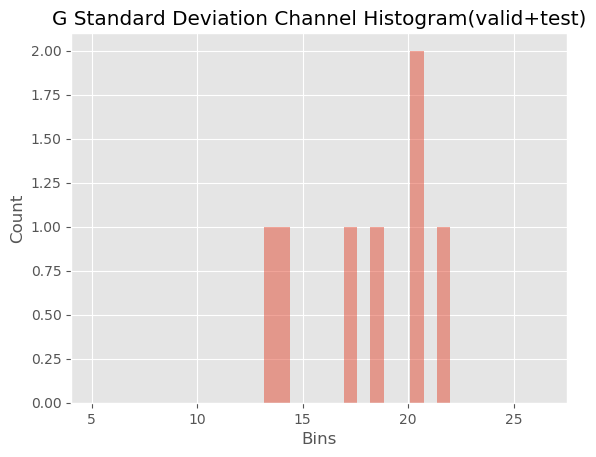

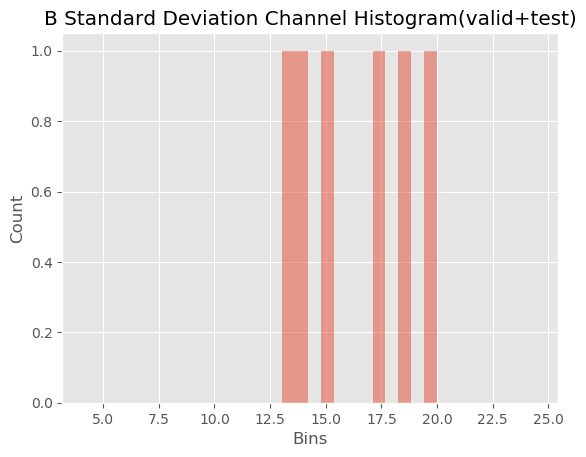

In [5]:
plot_sb(img_ids, stds, title="Standard Deviation", chart_type="RGB Standard Deviation", type_=type_)

## 3.4 Variance of Each Channel RGB

Plotting of Variance of each RGB Channel can be done using the following code. Similarly, there is a histogram showing the normal distribution among Variance in all the channels

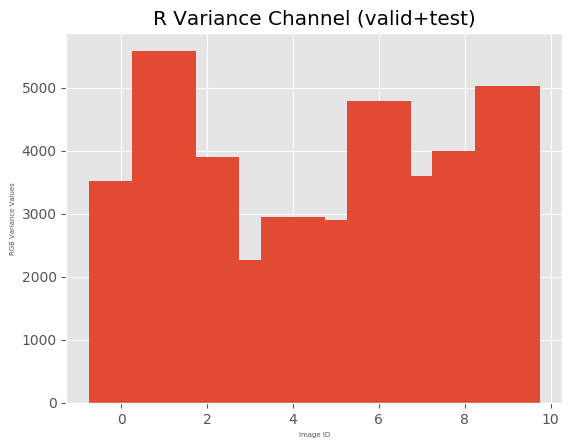

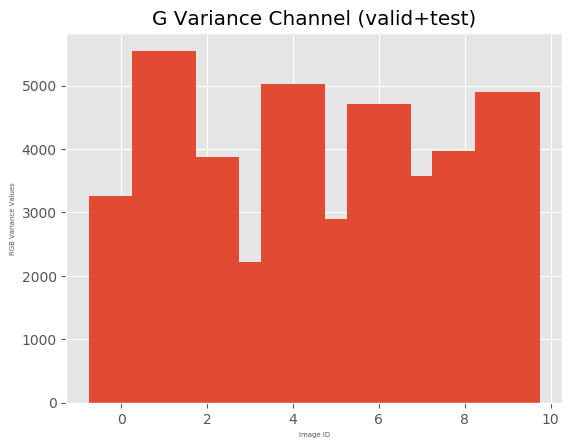

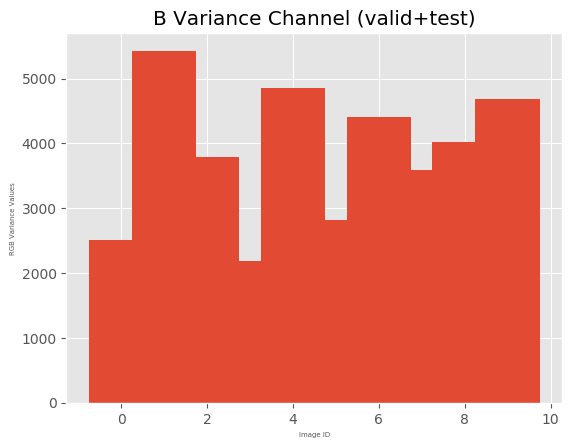

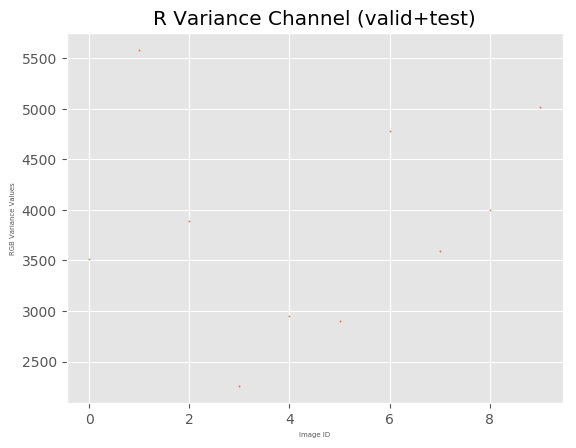

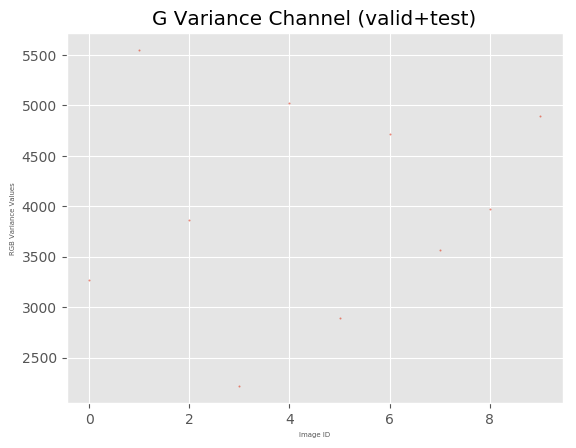

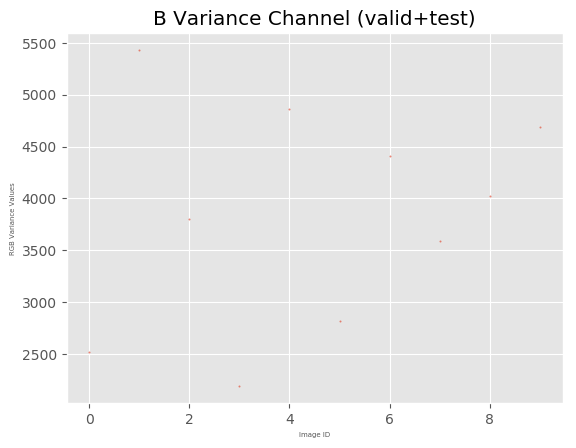

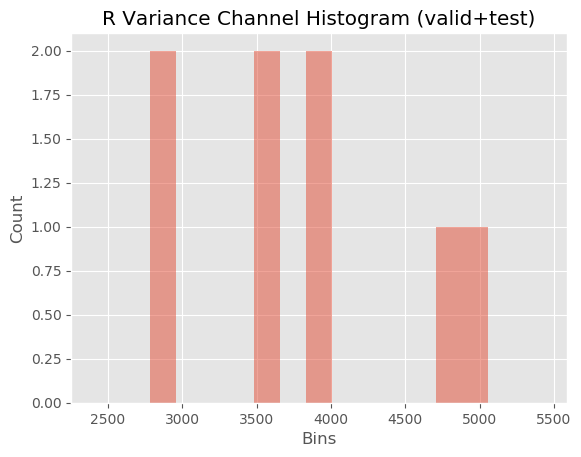

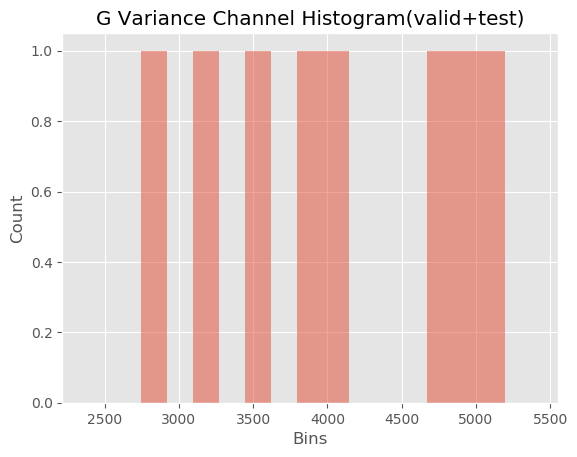

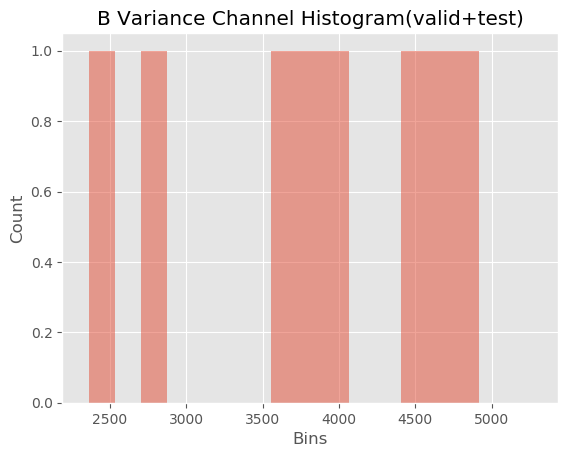

In [4]:
plot_sb(img_ids, vars, title="Variance", chart_type="RGB Variance", type_=type_)

## 3.5 Heatmap of Each Channel RGB

Plotting of Heatmap of each RGB Channel can be done using the following code. Heatmap will show the average pixel intensity of each RGB Channel amongs all the training or validation data. This heatmap generation will take a very long time due to 3-D plotting

In [ ]:
plot_3d_bar_chart(avg_pixel, '3D_HeatMap', type_)

Creating 3D Plot


## 3.6 Percentage of Car in Each Images

This shows the total percentage of a car in the each images. A small percentage of car among the image could result in inaccurate results as there is not much car labels to learn from. We found out that more of the images has about 15-35% of car in them. This could shows us that most part of the images are the background and the ground. 



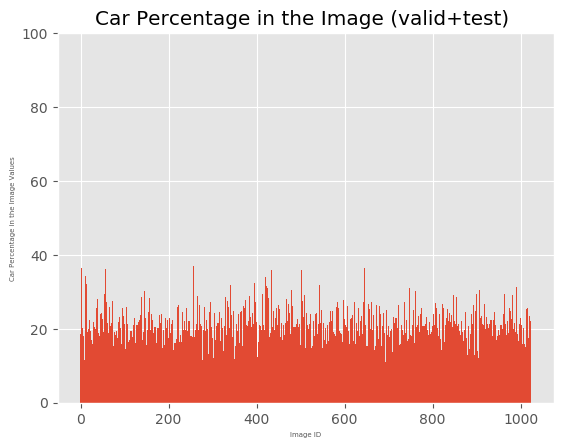

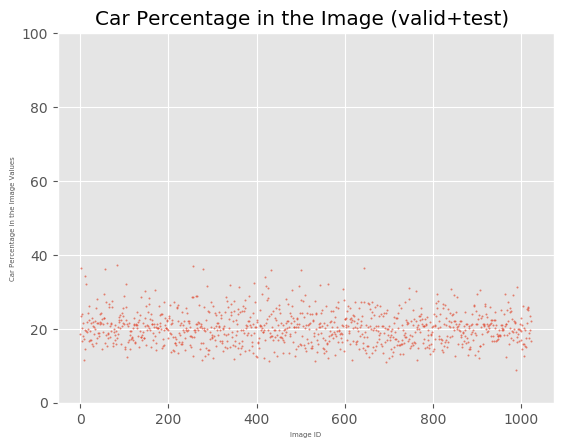

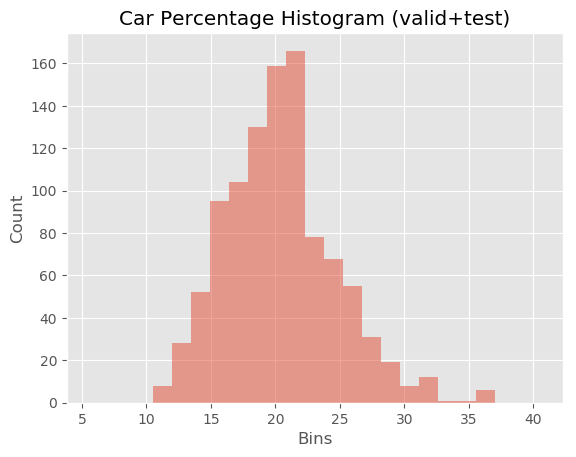

In [3]:
plot_car_percentage(type_, path)

# 4. Pre-processing
Data cleaning (missing features)
Data normalization (unbalanced scaling : max, z-scoring)
Important and consuming step to prepare the data for analysis

# 5. Data analysis with deep learning
Apply deep learning to solve your data problem :
Regression
Classification
Others
Compare different models :


## 1.Model selection
ICNET -- "ICNet for Real-Time Semantic Segmentation on High-Resolution Images," by Hengshuang Zhao, and et. al. (ECCV'18).

 ![](icnet.png)

## 2.Training Phase

## 3.Inference Phase

This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by:

2∗|X∩Y||X|+|Y|,
where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each image in the test set.

# 6. Analysis of results
Interpretation of results
Draw conclusions